In [57]:
%matplotlib inline
#from google.colab import files
from functools import partial
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.special
mpl.rcParams['figure.dpi'] = 100
plt.style.use('seaborn-dark')
np.random.seed(94115)


In [58]:
def simulate_lln(distribution, sequence_length=10 ** 3):
  # Generate the sequence {X_i}
  X_n = distribution(size=(sequence_length, 1))
  # Calculate the partial sums S_n = sum of X_i from i=1 to i=n
  partial_sums = X_n.cumsum(axis=0)
  # Calculate the partial sums for all n
  n_index = np.arange(start=1, stop=len(partial_sums)+1).reshape((-1, 1))
  # Divide by {n} to get the partial averages
  partial_means = np.divide(partial_sums, n_index)

  means = pd.DataFrame(partial_means, index=n_index[:,0], columns=['mean_n'])
  return means

# Let's make two functions for graphing.
def plot_one(means_one_sequence, title=""):
  """Use to plot one sequence of partial means"""
  label = r"Partial mean, $\frac{1}{n}\sum_{i=0}^n{X_i}$"
  ax = means_one_sequence.plot(linewidth=2, alpha=0.8, label=label, legend=True, color='#fa8174', figsize=(6, 4))
  ax.set_xlabel("Sample size, $n$", fontsize=18)
  ax.set_ylabel(r"Mean", fontsize=18)
  ax.tick_params(labelsize=18)
  ax.set_title("Law of large numbers\n{}".format(title), fontsize=18)
  leg = ax.legend(fontsize=18)

  return ax

def plot_many(means_data, title=""):
  """Use to plot many sequences of partial means"""
  ax = means_data.plot(linewidth=1, alpha=0.3, figsize=(6, 4), legend=False)
  ax.set_xlabel("Sample size, $n$", fontsize=18)
  ax.set_ylabel(r"Mean", fontsize=18)
  ax.tick_params(labelsize=18)
  ax.set_title("Law of large numbers\n{}".format(title), fontsize=18)

  return ax


# Code for 1.2 Selection bias (10 points)

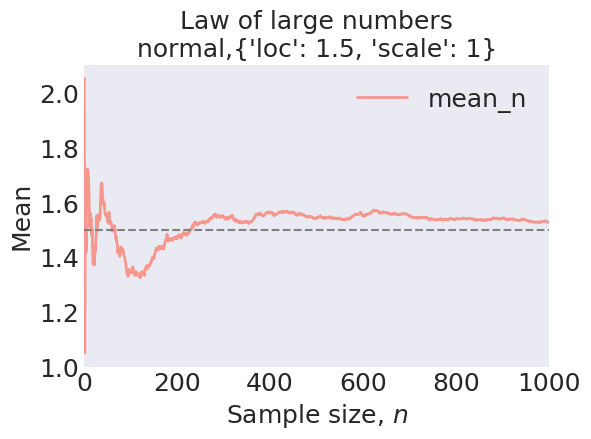

In [59]:
expectation_X = 1.5
standard_dev_X = 1
# We can use `partial` to fill in some of the arguments and leave some for later.
distribution = partial(np.random.normal, loc=expectation_X, scale=standard_dev_X)
means = simulate_lln(distribution)

title = ",".join([distribution.func.__name__, str(distribution.keywords)])
ax = plot_one(means.loc[0:10000], title)
ax.axhline(y=expectation_X, linestyle='--', color='grey')

In [60]:
# Total number of persons in the study
# Set large enough to make sampling variation negligible.
N = 10 ** 6

# Each person has an individual level of "charitability".
# We'll model this charitability as being normally distributed.
charitability = np.random.normal(loc=-1, scale=0.5, size=N)


# Draw the potential outcomes from a lognormal distribution.
# The outcome Y0 has a mean based on the charitability level:
# A higher charitability tends to increase the donation amount.
# Y1 is set to be identical to Y0. This means the ad has no effect!
# The technical term for the condition Y1=Y0 for all units is
# the "sharp null hypothesis."
Y0 = np.random.lognormal(mean=(charitability + 0.5), sigma=0.1, size=N)
Y1 = Y0.copy()


# The probability of searching for Doctors Without Borders is
# a function of the charitability level. People who are more 
# charitable are more likely to search for DWB.
# We assume that anyone who searches for DWB will see the DWB ad.
prob_search_dwb = scipy.special.expit(charitability)

D = np.random.binomial(n=1, p=prob_search_dwb)

Prob_D1 = np.sum(D)/N

print("Probability of D=1:   ",Prob_D1)

# Calculate the *actual* outcome.
Y = Y1 * D + Y0 * (1 - D)

# Put the data together for analysis.
df = pd.DataFrame({
    'D': D,
    'Y0': Y0, 
    'Y1': Y1, 
    'Y': Y,
    'delta': Y1 - Y0,
    'C': charitability,
})

print(df[(df.C > 0.5) & (df.C < 0.6)])

Probability of D=1:    0.278883
        D        Y0        Y1         Y  delta         C
580     1  3.035829  3.035829  3.035829    0.0  0.516812
1811    0  2.848258  2.848258  2.848258    0.0  0.567635
2697    1  2.896422  2.896422  2.896422    0.0  0.523142
3700    1  2.509519  2.509519  2.509519    0.0  0.520026
12801   1  3.100205  3.100205  3.100205    0.0  0.534966
...    ..       ...       ...       ...    ...       ...
993658  0  2.946198  2.946198  2.946198    0.0  0.585871
995277  1  2.595684  2.595684  2.595684    0.0  0.534225
995788  0  2.935649  2.935649  2.935649    0.0  0.566913
995965  1  2.796922  2.796922  2.796922    0.0  0.564656
996896  1  2.918690  2.918690  2.918690    0.0  0.579983

[672 rows x 6 columns]


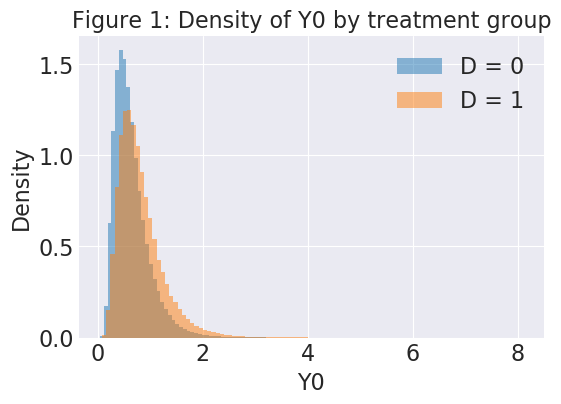

In [61]:
column_to_plot = 'Y0'
ax = df.query('D==0')[column_to_plot].hist(bins=100, alpha=0.5, density=True, label='D = 0')
ax = df.query('D==1')[column_to_plot].hist(bins=100, alpha=0.5, density=True, ax=ax, label='D = 1')
ax.legend(fontsize=16)
ax.set_xlabel(column_to_plot, fontsize=16)
ax.set_ylabel('Density', fontsize=16)
ax.set_title("Figure 1: Density of {} by treatment group".format(column_to_plot), fontsize=16)
ax.tick_params(labelsize=16)


In [62]:
# Here's another way to calculate the averages from the table.

# Calculate E[Y]
df['Y'].mean()

# Calculate E[Y0 | D=0]​ Problem Set 1

print("E[Y0|D=0] = {}".format(df.query("D == 0")['Y0'].mean()))

print("E[Y1|D=1] = {}".format(df.query("D == 1")['Y1'].mean()))

print("E[Y1|D=1] - E[Y0|D=0] = {}".format(df.query("D == 1")['Y1'].mean() - df.query("D == 0")['Y0'].mean()))


E[Y0|D=0] = 0.6425005916368577
E[Y1|D=1] = 0.8142764819919901
E[Y1|D=1] - E[Y0|D=0] = 0.1717758903551324


# Code for Question 1.3 Data-generating process for a null experiment 

In [63]:
D_exp = np.random.binomial(n=1,p = Prob_D1, size = N)

print('Probability after randomization',np.sum(D_exp)/N)

# Calculate the *actual* outcome.
Y = Y1 * D_exp + Y0 * (1 - D_exp)

# Put the data together for analysis.
df_new = pd.DataFrame({
    'D_exp': D_exp,
    'Y0': Y0, 
    'Y1': Y1, 
    'Y': Y,
    'delta': Y1 - Y0,
    'C': charitability,
})
print(df_new)

Probability after randomization 0.279019
        D_exp        Y0        Y1         Y  delta         C
0           0  0.648474  0.648474  0.648474    0.0 -0.916482
1           0  0.438889  0.438889  0.438889    0.0 -1.148697
2           1  0.797573  0.797573  0.797573    0.0 -0.881648
3           1  0.964974  0.964974  0.964974    0.0 -0.696266
4           0  0.285784  0.285784  0.285784    0.0 -1.800925
...       ...       ...       ...       ...    ...       ...
999995      0  0.516286  0.516286  0.516286    0.0 -1.090772
999996      0  1.485657  1.485657  1.485657    0.0 -0.198200
999997      0  1.253521  1.253521  1.253521    0.0 -0.350083
999998      0  0.731337  0.731337  0.731337    0.0 -0.665690
999999      0  0.477750  0.477750  0.477750    0.0 -1.136623

[1000000 rows x 6 columns]


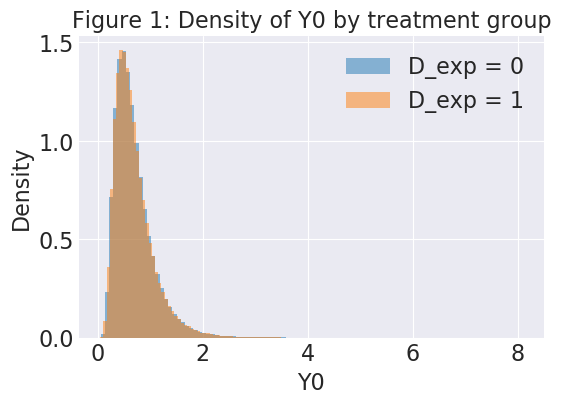

In [64]:
column_to_plot = 'Y0'
ax = df_new.query('D_exp==0')[column_to_plot].hist(bins=100, alpha=0.5, density=True, label='D_exp = 0')
ax = df_new.query('D_exp==1')[column_to_plot].hist(bins=100, alpha=0.5, density=True, ax=ax, label='D_exp = 1')
ax.legend(fontsize=16)
ax.set_xlabel(column_to_plot, fontsize=16)
ax.set_ylabel('Density', fontsize=16)
ax.set_title("Figure 1: Density of {} by treatment group".format(column_to_plot), fontsize=16)
ax.tick_params(labelsize=16)

In [65]:
df_new.groupby('D_exp').mean()

,Y0,Y1,Y,delta,C
D_exp,,,,,
0,0.690638,0.690638,0.690638,0.0,-0.999589
1,0.689805,0.689805,0.689805,0.0,-1.000759


In [66]:
df_new['Y'].mean()

# Calculate E[Y0 | D=0]​ Problem Set 1

print("E[Y0|D=0] = {}".format(df_new.query("D_exp == 0")['Y0'].mean()))

print("E[Y1|D=1] = {}".format(df_new.query("D_exp == 1")['Y1'].mean()))

print("E[Y1|D=1] - E[Y0|D=0] = {}".format(df_new.query("D_exp == 1")['Y1'].mean() - df_new.query("D_exp == 0")['Y0'].mean()))

E[Y0|D=0] = 0.6906383977341213
E[Y1|D=1] = 0.6898053703512108
E[Y1|D=1] - E[Y0|D=0] = -0.0008330273829104673


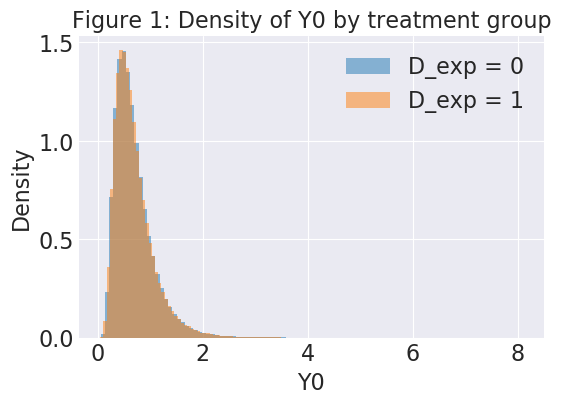

In [67]:
column_to_plot = 'Y0'
ax = df_new.query('D_exp==0')[column_to_plot].hist(bins=100, alpha=0.5, density=True, label='D_exp = 0')
ax = df_new.query('D_exp==1')[column_to_plot].hist(bins=100, alpha=0.5, density=True, ax=ax, label='D_exp = 1')
ax.legend(fontsize=16)
ax.set_xlabel(column_to_plot, fontsize=16)
ax.set_ylabel('Density', fontsize=16)
ax.set_title("Figure 1: Density of {} by treatment group".format(column_to_plot), fontsize=16)
ax.tick_params(labelsize=16)

# Code for Question 1.4 Data-generating process for an experiment with a treatment effect

In [68]:
Y1_new = Y0 + 0.3

df_1 = pd.DataFrame({
    'D': D,
    'Y0': Y0, 
    'Y1': Y1_new, 
    'Y': Y,
    'delta': Y1_new - Y0,
    'C': charitability,
})

df_1.groupby('D').mean()
print("E[Y0|D=0] = {}".format(df_1.query("D == 0")['Y0'].mean()))

print("E[Y1|D=1] = {}".format(df_1.query("D == 1")['Y1'].mean()))

print("E[Y1|D=1] - E[Y0|D=0] = {}".format(df_1.query("D == 1")['Y1'].mean() - df_1.query("D == 0")['Y0'].mean()))


E[Y0|D=0] = 0.6425005916368577
E[Y1|D=1] = 1.114276481991972
E[Y1|D=1] - E[Y0|D=0] = 0.47177589035511425


In [69]:
Y1_new = Y0 + 0.3

D_exp = np.random.binomial(n=1,p = Prob_D1, size = N)

print("Probability of D = 1:  ", np.sum(D_exp)/N)

# Calculate the *actual* outcome.
Y = Y1_new * D_exp + Y0 * (1 - D_exp)

# Put the data together for analysis.
df_new_1 = pd.DataFrame({
    'D_exp': D_exp,
    'Y0': Y0, 
    'Y1': Y1_new, 
    'Y': Y,
    'delta': Y1_new - Y0,
    'C': charitability,
})


Probability of D = 1:   0.278892


In [70]:
# Tabulate all the averages sliced by treatment vs. control
df_new_1.groupby('D_exp').mean()


,Y0,Y1,Y,delta,C
D_exp,,,,,
0,0.690175,0.990175,0.690175,0.3,-1.000064
1,0.691004,0.991004,0.991004,0.3,-0.999529


In [71]:

print("E[Y0|D=0] = {}".format(df_new_1.query("D_exp == 0")['Y0'].mean()))

print("E[Y1|D=1] = {}".format(df_new_1.query("D_exp == 1")['Y1'].mean()))

print("E[Y1|D=1] - E[Y0|D=0] = {}".format(df_new_1.query("D_exp == 1")['Y1'].mean() - df_new_1.query("D_exp == 0")['Y0'].mean()))


E[Y0|D=0] = 0.6901747911097335
E[Y1|D=1] = 0.9910037003542703
E[Y1|D=1] - E[Y0|D=0] = 0.30082890924453687


# Code for Question 5 Selection bias vs. big data (10 points)

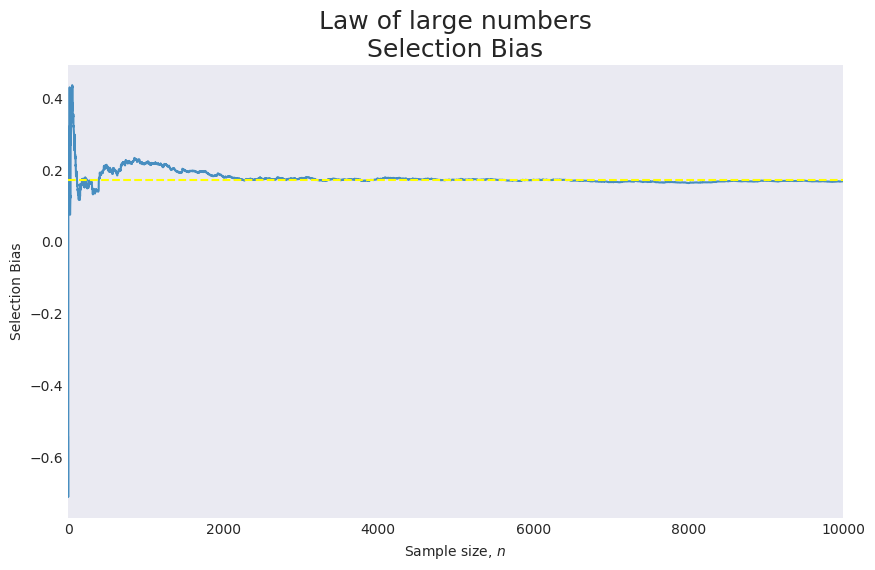

In [72]:
def selection_bias(df,n):
  import math
  df_agg = df.loc[:n].groupby('D').mean()

  k = df_agg['Y0']

  try:
    a = k[1]
  except:
    a = 0
  try:
    b = k[0]
  except:
    b = 0
  
  SB = a - b
  return SB
SB = selection_bias(df,2)

SB_df = pd.DataFrame(columns = ['Selection_Bias'])

for j in range(1,10001):
  SB_df.loc[j-1] = selection_bias(df,j)

def plot_many(means_data, title=""):
  """Use to plot many sequences of partial means"""
  ax = means_data.plot(linewidth=1.5, alpha=0.8, figsize=(10, 6), legend=False)
  ax.set_xlabel("Sample size, $n$", fontsize=10)
  ax.set_ylabel(r"Selection Bias", fontsize=10)
  ax.tick_params(labelsize=10)
  ax.set_title("Law of large numbers\n{}".format(title), fontsize=18)

  return ax
Sel_bias = df.query("D == 1")['Y0'].mean() - df.query("D == 0")['Y0'].mean()
plot_many(SB_df,'Selection Bias')
plt.gca()
plt.axhline(y=Sel_bias, linestyle='--', color='yellow')
plt.show()
